Classification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        80
           1       0.58      0.26      0.36        27

    accuracy                           0.77       107
   macro avg       0.69      0.60      0.61       107
weighted avg       0.74      0.77      0.73       107



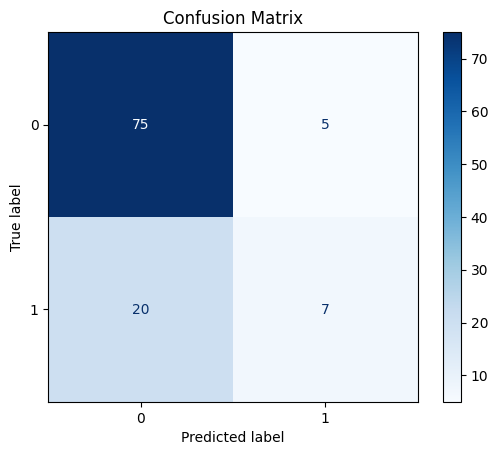

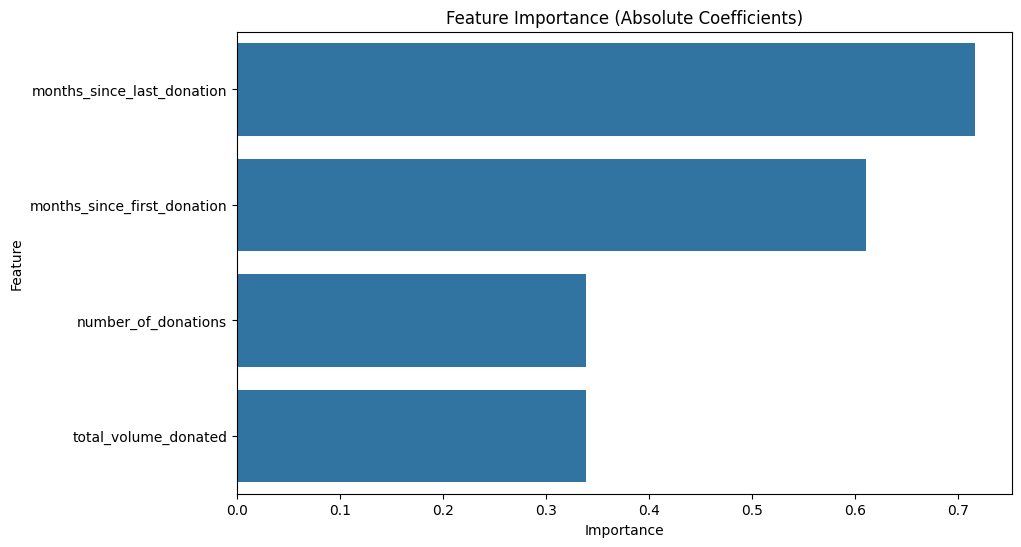

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Load the best model
model = joblib.load("../models/best_model.pkl")

#Load data splits
X_train, X_test, y_train, y_test = joblib.load("../data/processed/train_test_split.pkl")

# Prediction
y_pred =  model.predict(X_test)

# Evaluation Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues",values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Optional: Feature Importance
if hasattr(model, "coef_"): # Logistic Regression or linear models
    feature_names = pd.read_csv("../data/processed/cleaned_data.csv").drop("made_donation",axis=1).columns
    coefs = model.coef_[0]

    importance_df = pd.DataFrame({
        "Feature":feature_names,
        "Importance":np.abs(coefs)}).sort_values(by="Importance",ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature",data=importance_df)
    plt.title("Feature Importance (Absolute Coefficients)")
    plt.show()

elif hasattr(model, "feature_importances_"): #Tree-based models
    feature_names = pd.read_csv("../data/processed/cleaned_data.csv").drop("made_donation",axis=1).columns
    importance_df = pd.Dataframe({
        "Feature":feature_names,
        "Importance":model.feature_importances_}).sort_values(by="Importance",ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance",y="Feature",data=importance_df)
    plt.title("Feature Importance")
    plt.show()

else:
    print("Model type not supported for direct feature importance!!")






In [8]:
import lime 
import lime.lime_tabular
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Load your model (best performing one - Logistic Regression)
best_model = joblib.load("../models/best_model.pkl")


#Load the split data
X_train,x_test,y_train,y_test = joblib.load("../data/processed/train_test_split.pkl")

#Create LIME Explainer
df = pd.read_csv("../data/processed/cleaned_data.csv")
X = df.drop("made_donation",axis=1)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names = X.columns, #make sure X is available (df.drop("target",axis=1))
    class_names = ['Not Donated','Donated'],
    mode = 'classification'
)

#Pick an instance from the test set (eg index 5)
i = 5
exp = explainer.explain_instance(
    data_row = X_test[i],
    predict_fn = best_model.predict_proba
)

#Save Explanation as an HTML file
with open("lime_explanation.html","w",encoding="utf-8") as f:
        f.write(exp.as_html())

